This script loads raw neuropixel spike times and prepares data for further analysis by performing the following steps:
1. Select which task entries to analyze
2. Load behavioral data and select good trials based on the reach time distributions.
3. Load neuropixel spike times
    - Bin spike times
    - Align data to the even of interest
    - Smooth timeseries with a Gaussian kernel
4. Saves preprocessed data
5. Plots basic neural data figures
    - Trial averaged firing rate
    - Raster plots
    - Raster plots organized by target direction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aopy
import os
import pandas as pds
from db import dbfunctions as db
from ipywidgets import interactive, widgets
import scipy
import h5py
from tqdm.auto import tqdm 
import seaborn as sn
import sklearn
import multiprocessing as mp
import time
import glob
from datetime import date

In [2]:
# Paths
data_path_preproc = '/media/moor-data/preprocessed.new/'
data_path_raw = '/media/moor-data/raw/neuropixels/'
save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/np_analysis_preproc_data"
behavior_save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/behavior"

# General data parameters
subject = 'beignet'
task_coords = 'yzx'
task_perturb = None
task_rotation = 0

# Task event code definitions
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CURSOR_ENTER_PERIPHERAL_TARGET = list(range(81,89))
PERIPHERAL_TARGET_ON = list(range(17,25))
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
PAUSE = 254
TIME_ZERO = 238
TRIAL_END = 239

# Select which event to align to
# align_event = 'TARGET ONSET'
# align_event = 'GO CUE'
align_event = 'MOVEMENT ONSET'
# align_event = 'ENTER TARGET'
END_TRIAL_CODE = REWARD


# Trial selection parameters
trial_filter = lambda t: CENTER_TARGET_OFF in t
success_rate_window = 19
reach_time_std_thresh = 3

# Neuropixel data parameters
implant_name = ['NP_Insert72', 'NP_Insert137']
start_date = '2023-07-13'
end_date = date.today()
elec_config = 'bottom'
spike_bin_width_mc = 0.01 #[s]
smooth_width = 150
smooth_nstd = 3

# Task data selection parameters
tbefore_mc = 0.5
tafter_mc = 1

# Quality metrics for unit selection
min_trial_prop = 0.75

# Visualization parameters
colors = sn.color_palette(n_colors=9)

In [3]:
def get_cursor_leave_center_time(data, samplerate, target_radius):
    '''
    Compute the time when the cursor leaves the center target radius
    
    Args:
        traj (ntrials list of (nt,2)): x,y trajectory data
        samplerate
        target_radius (float): the radius of the center target
        
    Returns:
        cursor_leave_center_time (ntrials list): the time when the cursor leaves the center target radius
    '''
    ntr = len(data)
    cursor_leave_center_time = []
    
    for itr in range(ntr):
        t_axis = np.arange(data[itr].shape[0])/samplerate
        
        dist = np.sqrt(data[itr][:,0]**2 + data[itr][:,1]**2)
        leave_idx = np.where(dist>target_radius)[0]
        temp = t_axis[leave_idx]
        cursor_leave_center_time.append(temp[0])
    
    return cursor_leave_center_time

def get_cursor_leave_center_idx(data, target_radius):
    '''
    Compute the time when the cursor leaves the center target radius
    
    Args:
        traj (ntrials list of (nt,2)): x,y trajectory data
        target_radius (float): the radius of the center target
        
    Returns:
        cursor_leave_center_time (ntrials list): the time when the cursor leaves the center target radius
    '''
    ntr = len(data)
    cursor_leave_center_time = []
    leave_idx = []
    for itr in range(ntr):
        dist = np.sqrt(data[itr][:,0]**2 + data[itr][:,1]**2)
        leave_idx.append(np.where(dist>target_radius)[0][0])
    
    return leave_idx

def smooth_timeseries_gaus(timeseries_data, samplerate, width, nstd=3, conv_mode='same'):
    '''
    Smooths across 2 
    
    Args:
        timeseries_data (ntime, ...)
        samplerate (int): Sample rate of timeseries
        width (float): Width of the gaussian in time [ms] from -nstd to +nstd
        nstd (float/int): Number of standard deviations to be used in the filter calculation.
        conv_mode (str): Sets the size of the output. Takes eithe 'full', 'valid', or 'same'. See scipy.signal.convolve for full documentationat
        
    Returns: 
        smoothed_timeseries
    '''
    sample_std = (width/nstd)*(samplerate/(1000)) # Convert from s to ms
    x = np.arange(-sample_std*nstd, nstd*sample_std+1)
    gaus_filter = (1/(sample_std*np.sqrt(2*np.pi)))*np.exp(-(x**2)/(2*sample_std**2))
    return np.apply_along_axis(scipy.signal.convolve, 0, timeseries_data, gaus_filter, mode=conv_mode, method='direct')

# Select relevant task entries

In [4]:
if align_event == 'TARGET ONSET':
    START_TRIAL_CODE = PERIPHERAL_TARGET_ON
    START_TRIAL_CODE_BEHAVIOR = PERIPHERAL_TARGET_ON
    align_movement_onset = False
elif align_event == 'GO CUE':
    START_TRIAL_CODE = CENTER_TARGET_OFF
    START_TRIAL_CODE_BEHAVIOR = CENTER_TARGET_OFF
    align_movement_onset = False
elif align_event == 'MOVEMENT ONSET':
    START_TRIAL_CODE = CENTER_TARGET_OFF
    START_TRIAL_CODE_BEHAVIOR = CENTER_TARGET_OFF
    align_movement_onset = True
elif align_event == 'ENTER TARGET':
    START_TRIAL_CODE = CURSOR_ENTER_PERIPHERAL_TARGET
    START_TRIAL_CODE_BEHAVIOR = CENTER_TARGET_OFF
    align_movement_onset = False

In [5]:
# Load neuropixel center-out task data
mc_entries =  db.get_task_entries(subject__name=subject, task__name='manual control', date=(start_date, end_date))
mc_entries = [me for me in mc_entries if 'neuropixel_port1_drive_type' in me.task_params and me.task_params['neuropixel_port1_drive_type'] in implant_name
             and me.task_params['rotation']==task_coords and me.entry_name != 'flash']
dates = np.unique([me.date.date() for me in mc_entries])

In [6]:
print(mc_entries, dates)

[2023-07-13 13:06:46.567495: beignet on manual control task, id=9923, 2023-07-13 13:09:07.735090: beignet on manual control task, id=9924, 2023-07-13 13:41:06.548415: beignet on manual control task, id=9925, 2023-07-14 12:10:54.765135: beignet on manual control task, id=9928, 2023-07-14 13:12:04.967348: beignet on manual control task, id=9931, 2023-07-18 14:56:35.442092: beignet on manual control task, id=9940, 2023-07-19 11:49:20.267279: beignet on manual control task, id=9958, 2023-08-28 14:03:24.447446: beignet on manual control task, id=10802, 2023-08-29 15:21:49.044992: beignet on manual control task, id=10812, 2023-08-30 12:01:38.097517: beignet on manual control task, id=10820, 2023-08-31 13:12:42.458972: beignet on manual control task, id=10828, 2023-09-01 11:55:47.553120: beignet on manual control task, id=10835, 2023-11-16 13:24:31.399857: beignet on manual control task, id=12269, 2023-11-17 14:26:48.886701: beignet on manual control task, id=12290, 2023-11-17 14:56:35.517341

# Load behavioral data

In [7]:
cursor_traj = []
success_rate = []
reach_times = []
trial_segs = []
trial_times = []
target_idx = []
for idate, date in enumerate(tqdm(dates)):
    within_day_mc_entries = [me for me in mc_entries if me.date.date() == date]
    session_number = 0
    for ime, me in enumerate(within_day_mc_entries):
        exp_data, exp_metadata = aopy.data.load_preproc_exp_data(data_path_preproc, subject, me.id, me.date.date())
        trial_segs_single_sess, trial_times_single_sess = aopy.preproc.base.get_trial_segments(exp_data['events']['code'], exp_data['events']['timestamp'],
                                               START_TRIAL_CODE, END_TRIAL_CODE)
        
        # Only look at sessions with trials
        if trial_times_single_sess.shape[0] > 0:
            success_rate_single_sess = aopy.analysis.calc_success_rate(exp_data['events']['code'], exp_data['events']['timestamp'],
                           START_TRIAL_CODE_BEHAVIOR, END_TRIAL_CODE, REWARD, window_size=success_rate_window)
            cursor_traj_single_sess_temp, _ = aopy.data.bmi3d.get_kinematic_segments(data_path_preproc, subject, me.id, me.date.date(), 
                                START_TRIAL_CODE_BEHAVIOR, END_TRIAL_CODE, trial_filter=trial_filter, datatype='cursor')

            if align_movement_onset:
                cursor_leave_idx_day = get_cursor_leave_center_idx(cursor_traj_single_sess_temp, exp_metadata['target_radius'])
                cursor_traj_single_sess = np.array([cursor_traj_single_sess_temp[itr][cursor_leave_idx_day[itr]:] for itr in range(len(cursor_traj_single_sess_temp))], dtype='object')
            else:
                cursor_traj_single_sess = cursor_traj_single_sess_temp
                
            reach_times_single_sess = [cursor_traj_single_sess[it].shape[0]/exp_metadata['cursor_interp_samplerate'] for it in range(len(cursor_traj_single_sess))]        
            
            if session_number == 0:
                cursor_traj_single_day = cursor_traj_single_sess
                success_rate_single_day = success_rate_single_sess
                reach_times_single_day = reach_times_single_sess
                trial_segs_single_day = trial_segs_single_sess
                trial_times_single_day = trial_times_single_sess
                
            else:
                cursor_traj_single_day = np.concatenate((cursor_traj_single_day, cursor_traj_single_sess))
                # cursor_traj_single_day = cursor_traj_single_day + cursor_traj_single_sess
                success_rate_single_day = np.concatenate((success_rate_single_day, success_rate_single_sess))
                reach_times_single_day = np.concatenate((reach_times_single_day, reach_times_single_sess))
                trial_segs_single_day = np.concatenate((trial_segs_single_day, trial_segs_single_sess), axis=0)
                trial_times_single_day = np.concatenate((trial_times_single_day, trial_times_single_sess), axis=0)
            
            session_number+=1
    
    cursor_traj.append(cursor_traj_single_day)
    success_rate.append(success_rate_single_day)
    reach_times.append(np.array(reach_times_single_day))
    trial_segs.append(trial_segs_single_day)
    trial_times.append(trial_times_single_day)
    if START_TRIAL_CODE == CENTER_TARGET_OFF:
        target_idx.append(np.array(trial_segs_single_day)[:,1]-CURSOR_ENTER_CENTER_TARGET)
    elif START_TRIAL_CODE == CURSOR_ENTER_CENTER_TARGET:
        target_idx.append(np.array(trial_segs_single_day)[:,3]-CURSOR_ENTER_CENTER_TARGET)
    elif START_TRIAL_CODE == PERIPHERAL_TARGET_ON:
        target_idx.append(np.array(trial_segs_single_day)[:,2]-CURSOR_ENTER_CENTER_TARGET)
    elif START_TRIAL_CODE == CURSOR_ENTER_PERIPHERAL_TARGET:
        target_idx.append(np.array(trial_segs_single_day)[:,0]-CURSOR_ENTER_CENTER_TARGET)

  0%|          | 0/11 [00:00<?, ?it/s]

In [8]:
# Get specs of loaded data
cursor_samplerate = exp_metadata['cursor_interp_samplerate']
n_mctrials = [len(cursor_traj[i]) for i in range(len(cursor_traj))]
ntargets = len(np.unique(target_idx[0]))
unique_targets = aopy.data.bmi3d.get_target_locations(data_path_preproc, subject, me.id, me.date.date(), np.unique(target_idx[-1]))
reach_time_thresh = np.median(np.hstack(reach_times)) + (np.median(np.hstack(reach_times))-np.min(np.hstack(reach_times)))
good_trial_idx1 = [reach_times[id] <= reach_time_thresh for id in range(len(reach_times))]
# good_trial_idx = [aopy.analysis.base.find_outliers(reach_times[id].reshape(-1, 1), reach_time_std_thresh)[0] for id in range(len(reach_times))]

In [9]:
# Define 'good_trial_idx' so that all targets from all sessions have the same number of trials
min_trials_to_target = np.min([np.min(np.unique(target_idx[id][good_trial_idx1[id]], return_counts=True)[1]) for id in range(len(dates))])
# print(itarget, good_trial_idx1[1])
good_trial_idx = []
for idate in range(len(dates)):
    good_trial_idx_temp = []    
    [good_trial_idx_temp.extend(np.where(np.logical_and(target_idx[idate]==itarget+1, good_trial_idx1[idate]))[0][:min_trials_to_target]) for itarget in range(ntargets)]
    good_trial_idx_mask = np.zeros(n_mctrials[idate], dtype=bool)
    good_trial_idx_mask[good_trial_idx_temp] = True
    good_trial_idx.append(good_trial_idx_mask)
    
ngood_trials = [np.sum(good_trial_idx[id]) for id in range(len(good_trial_idx))]

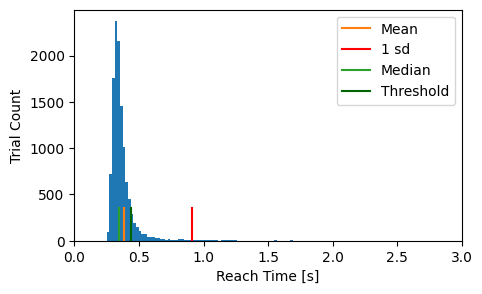

In [10]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.hist(np.hstack(reach_times), bins=2000)
ax.set(xlim=[0, 3], xlabel='Reach Time [s]', ylabel='Trial Count')
ax.plot([np.mean(np.hstack(reach_times)), np.mean(np.hstack(reach_times))], [0, 350], label='Mean')
ax.plot([np.median(np.hstack(reach_times))+np.std(np.hstack(reach_times)),np.median(np.hstack(reach_times))+np.std(np.hstack(reach_times))], [0, 350],
        color='red', label='1 sd')
ax.plot([np.median(np.hstack(reach_times)), np.median(np.hstack(reach_times))], [0, 350], label='Median')
ax.plot([reach_time_thresh, reach_time_thresh], [0, 350], color='darkgreen', label='Threshold')
plt.legend()
plt.show()

## Plot behavioral data

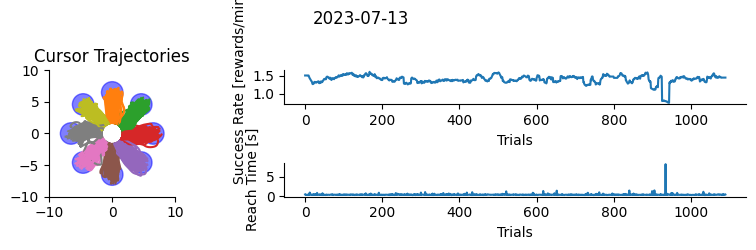

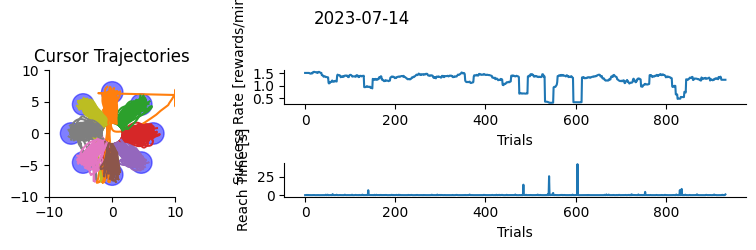

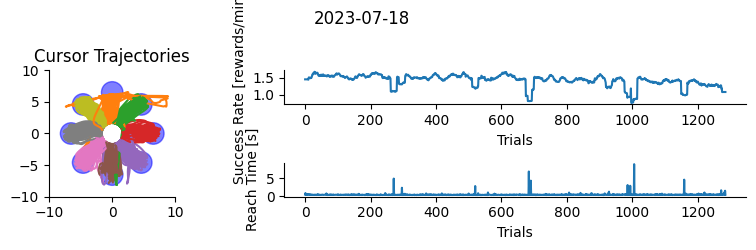

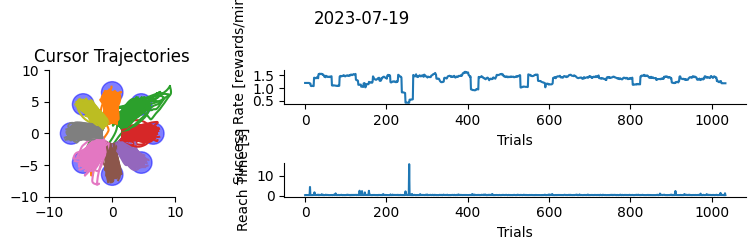

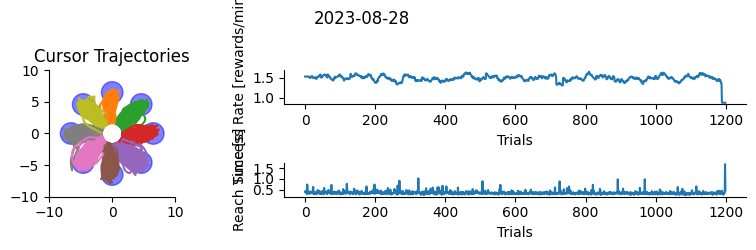

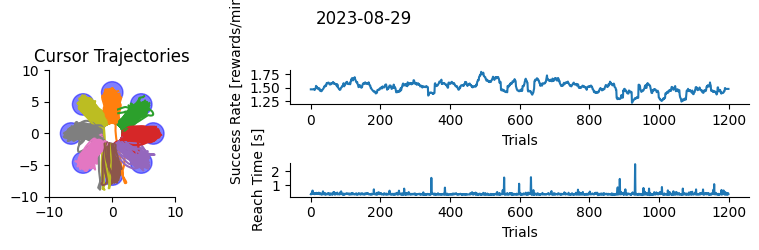

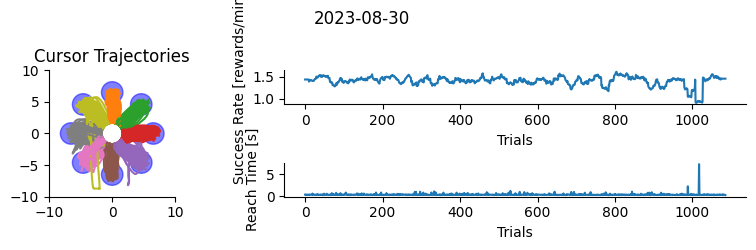

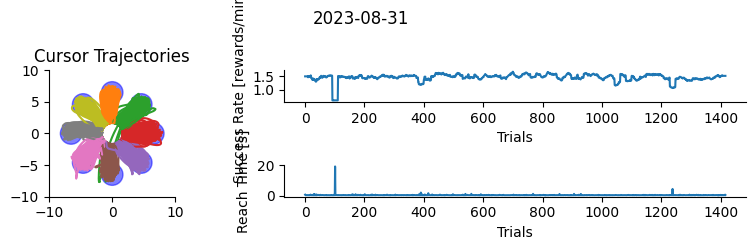

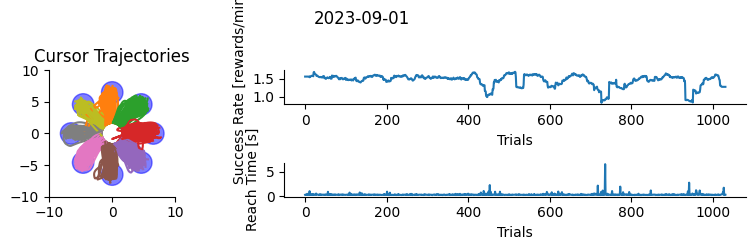

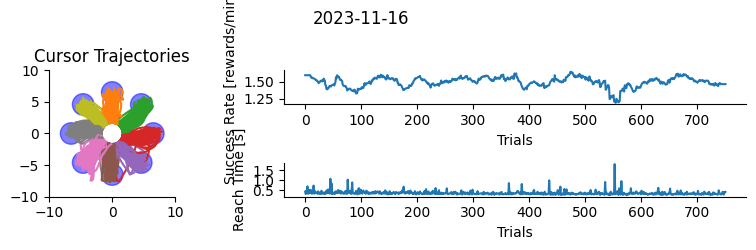

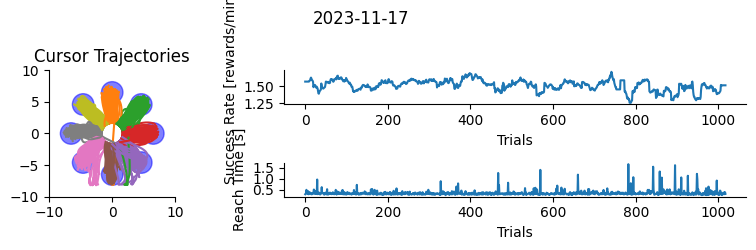

In [11]:
# Without bad trials removed
for idate, date in enumerate(dates):
    
    fig, ax = plt.subplot_mosaic("ABB;ACC",figsize=(8,2.5))
    labels=target_idx[idate].astype(int)
    style = plt.cycler(color=[colors[i] for i in labels])
    ax['A'].set_prop_cycle(style)
    aopy.visualization.plot_trajectories(cursor_traj[idate],  ax=ax['A'])
    aopy.visualization.plot_targets(unique_targets, exp_metadata['target_radius'], ax=ax['A'])
    ax['A'].set_title('Cursor Trajectories')
    ax['A'].spines.right.set_visible(False)
    ax['A'].spines.top.set_visible(False)
    ax['A'].set(xlim=(-10, 10), ylim=(-10,10), xlabel='', ylabel='')

    # Plot success rate
    # ax['B'].plot(np.arange(success_rate_window/2, n_mctrials[idate]-(success_rate_window/2)+1), success_rate[idate])
    ax['B'].plot(np.arange(n_mctrials[idate]), success_rate[idate])
    ax['B'].set(xlabel='Trials', ylabel='Success Rate [rewards/min]')
    ax['B'].spines.right.set_visible(False)
    ax['B'].spines.top.set_visible(False)

    # Plot reach time
    ax['C'].plot(reach_times[idate])
    ax['C'].set(xlabel='Trials', ylabel='Reach Time [s]')
    ax['C'].spines.right.set_visible(False)
    ax['C'].spines.top.set_visible(False)
    plt.suptitle(date)
    fig.tight_layout()
    plt.show()
    # if save_figs:
    #     aopy.visualization.savefig(full_save_dir, subject+'_mc_behavior.svg')   

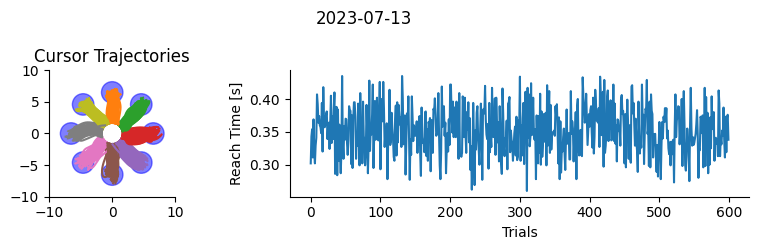

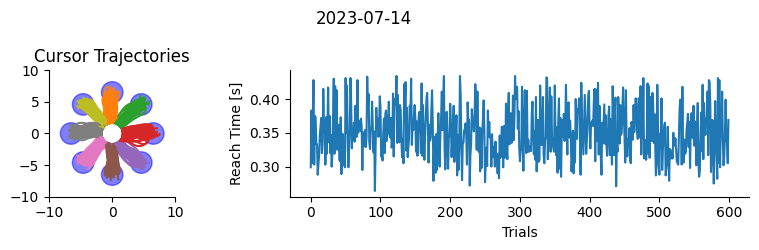

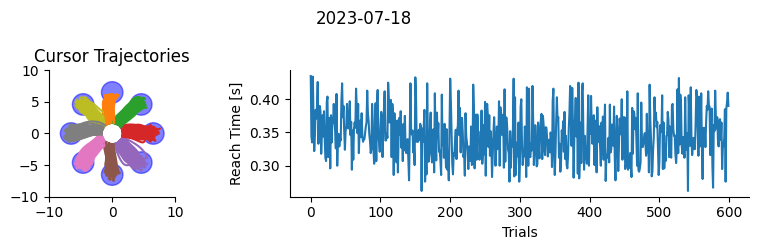

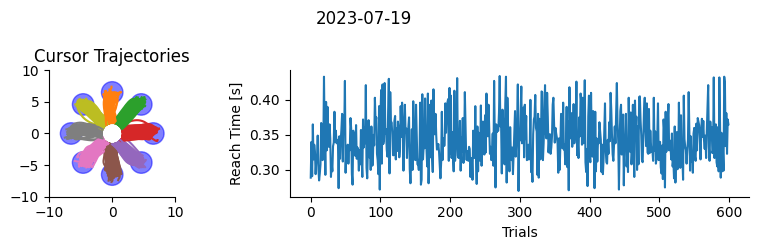

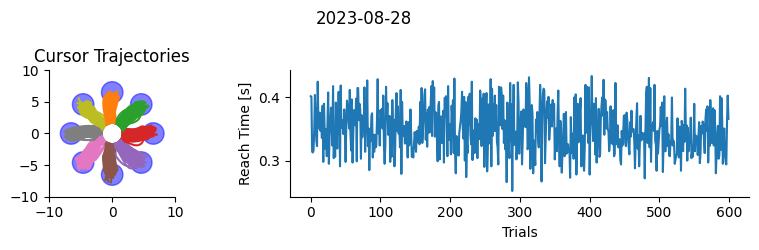

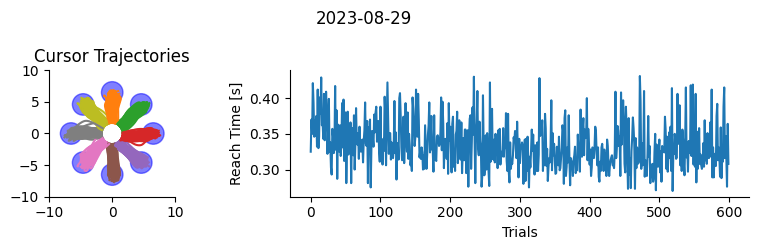

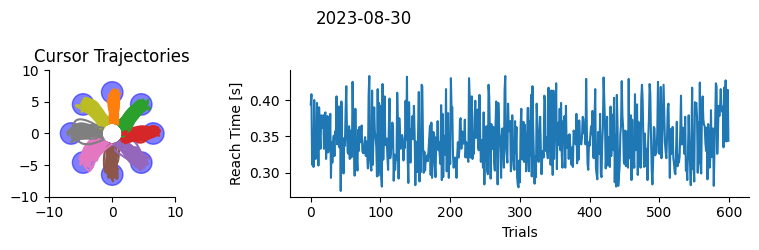

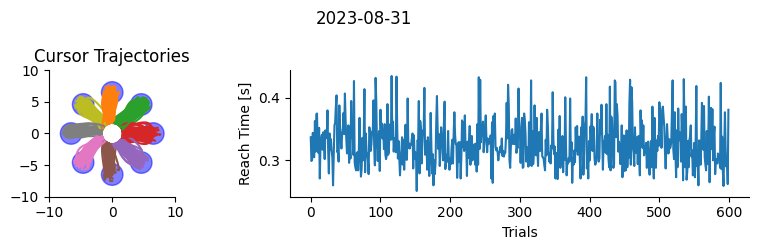

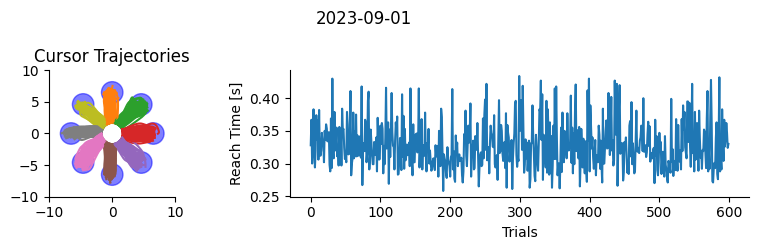

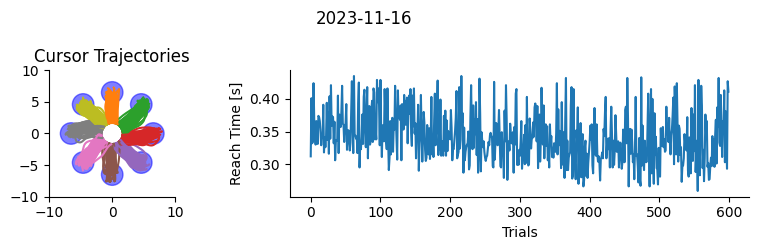

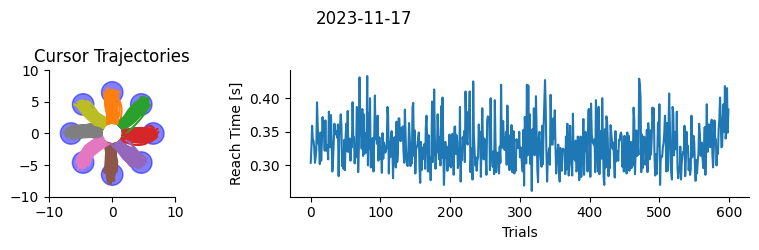

In [12]:
# With bad trials removed from trajectories and reach times.
cursor_traj_clean = [[traj for itraj, traj in enumerate(cursor_traj[idate]) if good_trial_idx[idate][itraj]] for idate, _ in enumerate(dates)]
for idate, date in enumerate(dates):
    
    fig, ax = plt.subplot_mosaic("ABB",figsize=(8,2.5))
    labels=target_idx[idate][good_trial_idx[idate]].astype(int)
    style = plt.cycler(color=[colors[i] for i in labels])
    ax['A'].set_prop_cycle(style)
    aopy.visualization.plot_trajectories(cursor_traj_clean[idate],  ax=ax['A'])
    aopy.visualization.plot_targets(unique_targets, exp_metadata['target_radius'], ax=ax['A'])
    ax['A'].set_title('Cursor Trajectories')
    ax['A'].spines.right.set_visible(False)
    ax['A'].spines.top.set_visible(False)
    ax['A'].set(xlim=(-10, 10), ylim=(-10,10), xlabel='', ylabel='')

    # Plot reach time
    ax['B'].plot(reach_times[idate][good_trial_idx[idate]])
    ax['B'].set(xlabel='Trials', ylabel='Reach Time [s]')
    ax['B'].spines.right.set_visible(False)
    ax['B'].spines.top.set_visible(False)

    plt.suptitle(date)
    fig.tight_layout()
    plt.show()

# Load neuropixel data

In [13]:
ntime = np.round((tafter_mc + tbefore_mc)/spike_bin_width_mc).astype(int)
trial_time_axis = np.arange(-tbefore_mc, tafter_mc, spike_bin_width_mc)
ntargets = len(np.unique(target_idx[0]))

In [ ]:
# Concatenate trials across sessions within a day
# TODO: concatenate data if recorded at the same stim site but during different days
start = time.time()
spike_times = []
unit_labels = []
trial_times = []
spike_segs = []
spike_align = []
spike_align_raster = []
spike_labels = []
spike_pos = []
ks_labels = []
recording_site = []
implant_name = []
for idate, date in enumerate(tqdm(dates)):
    within_day_mc_entries = [me for me in mc_entries if me.date.date() == date]

    ########################################################
    ### FUNCTION 1 - concatenate spike times across sessions
    ########################################################
    session_number = 0

    # Load data from sessions recorded on the same day and combine 
    for ime, me in enumerate(within_day_mc_entries):
        # Load data
        exp_data, exp_metadata = aopy.data.load_preproc_exp_data(data_path_preproc, subject, me.id, me.date.date())
        filename_mc = aopy.data.get_preprocessed_filename(subject, me.id, me.date.date(), 'ap')
        try:
            ap_data = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_mc, 'ap')
            ap_metadata = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_mc, 'metadata')

        except:
            continue
        
        # Parse behavioral data
        cursor_traj_single_sess_temp, _ = aopy.data.bmi3d.get_kinematic_segments(data_path_preproc, subject, me.id, me.date.date(), 
                                START_TRIAL_CODE, END_TRIAL_CODE, trial_filter=trial_filter, datatype='cursor')
        _, trial_times_single_sess = aopy.preproc.base.get_trial_segments(exp_data['events']['code'], exp_data['events']['timestamp'],
                                               START_TRIAL_CODE, END_TRIAL_CODE)
        
        if align_movement_onset:
            trial_times_single_sess[:,0] = trial_times_single_sess[:,0] + np.array(get_cursor_leave_center_time(cursor_traj_single_sess_temp, exp_metadata['cursor_interp_samplerate'], exp_metadata['target_radius']))
        
        # Combine data
        if session_number == 0:
            trial_times_day = trial_times_single_sess
            unit_labels_day = ap_data['unique_label']
            spike_times_day = ap_data['unit']
            ks_labels_day = ap_data['ks_label'][:,1]
        else:
            trial_times_day = np.concatenate((trial_times_day, trial_times_single_sess+max_time), axis=0)
            good_unit_label_mask = np.in1d(unit_labels_day, ap_data['unique_label'])
            units_to_remove = unit_labels_day[np.logical_not(good_unit_label_mask)]   # Remove units that 
            unit_labels_day = unit_labels_day[good_unit_label_mask]                       # Only keep units that are in both sessions 
            for _, unitid in enumerate(unit_labels_day):
                spike_times_day[str(unitid)] = np.concatenate((spike_times_day[str(unitid)], ap_data['unit'][str(unitid)]+max_time), axis=0)
        
            # Remove any units that aren't in the latest session 
            unit_labels_day = unit_labels_day[np.in1d(unit_labels_day, units_to_remove, invert=True)]
            for _, bad_unitid in enumerate(units_to_remove):
                del spike_times_day[str(bad_unitid)]
        
        # Set new parameters for next session
        max_time = trial_times_day[-1,-1]
        session_number += 1 
    ########################################################
    
    unit_labels.append(unit_labels_day)
    spike_times.append(spike_times_day) # Assumes spike labels are consistent across recording sessions (works if recorded on the same day, but otherwise it does not)
    trial_times.append(trial_times_day)
    recording_site.append(exp_metadata['neuropixel_port1_site']) # TODO: quirry this from the db instead of metadata
    implant_name.append(me.task_params['neuropixel_port1_drive_type'])
    spike_pos.append(ap_data['pos'])
    
    ########################################################
    
    spike_segs_day = {}
    spike_align_day = np.zeros((ntime, ngood_trials[idate], len(unit_labels_day)))
    for iunit, unitid in enumerate(unit_labels_day):
        binned_spikes, time_bins = aopy.precondition.bin_spike_times(spike_times_day[str(unitid)], 0, trial_times_day[-1,1]+10, spike_bin_width_mc)

        # Align trial segments
        spike_segs_day[str(unitid)] = aopy.preproc.base.get_data_segments(binned_spikes, trial_times_day, 1/spike_bin_width_mc)

        # Trial align 
        spike_align_day[:,:,iunit] = aopy.preproc.trial_align_data(binned_spikes, trial_times_day[:,0], tbefore_mc, tafter_mc, 1/spike_bin_width_mc)[:,0,good_trial_idx[idate]]


    spike_segs.append(spike_segs_day)
    spike_align.append(smooth_timeseries_gaus(spike_align_day, 1/spike_bin_width_mc, width=smooth_width, nstd=smooth_nstd))
    spike_align_raster.append(spike_align_day)

  0%|          | 0/11 [00:00<?, ?it/s]

# Save data

In [ ]:
# TODO replace this by querying database instead
if recording_site[2] == 55 and recording_site[4] == 55:
    recording_site[4] = 47
    recording_site[2] = 56

In [ ]:
neuropixel_preproc_data = {}
neuropixel_preproc_data['spike_times'] = spike_times
neuropixel_preproc_data['unit_labels'] = unit_labels
neuropixel_preproc_data['trial_times'] = trial_times
neuropixel_preproc_data['spike_align'] = spike_align # Smoothed timeseries
neuropixel_preproc_data['spike_align_raster'] = spike_align_raster
neuropixel_preproc_data['spike_labels'] = spike_labels
neuropixel_preproc_data['ks_labels'] = ks_labels
neuropixel_preproc_data['recording_site'] = recording_site
neuropixel_preproc_data['target_idx'] = target_idx
neuropixel_preproc_data['good_trial_idx'] = good_trial_idx
neuropixel_preproc_data['tbefore_mc'] = tbefore_mc
neuropixel_preproc_data['tafter_mc'] = tafter_mc
neuropixel_preproc_data['spike_bin_width_mc'] = spike_bin_width_mc
neuropixel_preproc_data['trial_time_axis'] = trial_time_axis
neuropixel_preproc_data['implant'] = implant_name
neuropixel_preproc_data['spike_pos'] = spike_pos
neuropixel_preproc_data['mc_entries'] = mc_entries
neuropixel_preproc_data['cursor_traj'] = cursor_traj_clean

In [ ]:
start = time.time()
aopy.data.base.pkl_write(f"{subject}_{align_event}", neuropixel_preproc_data, save_dir)
print(time.time()-start)

In [ ]:
start = time.time()
test = aopy.data.base.pkl_read(f"{subject}_{align_event}", save_dir)
print(time.time()-start)

In [ ]:
print(test.keys())

In [ ]:
print(test['mc_entries'])